In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mitbit-arrhythmia-database/mitbih_database/112annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/233.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/118annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/231.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/207.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/115annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/123annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/102annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/209.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/203annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/202annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/215annotat

In [2]:
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential , Model
from keras.layers import Dense, LSTM, Dropout, Softmax, Bidirectional, Flatten
import math
from sklearn.metrics import mean_squared_error

In [3]:
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers

In [4]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [5]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'A', 'V', 'F', 'f']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [6]:
filenames = next(os.walk(path))[2]
records = list()
annotations = list()
filenames.sort()

In [7]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)
    else:
        annotations.append(path + filename + file_extension)

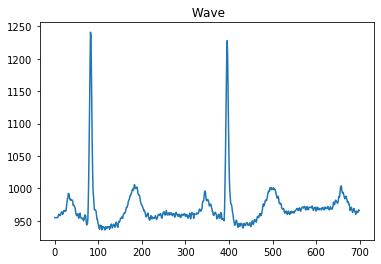

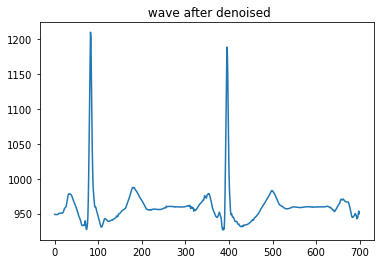

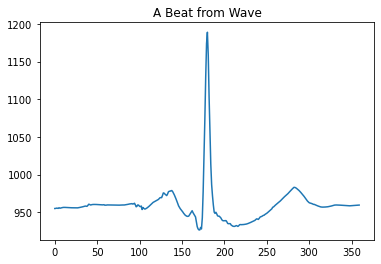

(86470, 360) (86470,)


In [8]:
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 1:
        plt.title(" Wave")
        plt.plot(signals[0:700])
        plt.show()
    signals = denoise(signals)
    if r is 1:
        plt.title(" wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()
        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True
                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))

In [9]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
print(np.shape(X))

(86470, 361)


In [10]:
X_train_df = pd.DataFrame(X)
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,963.374455,963.536949,964.756621,965.399062,966.017086,966.375099,966.610054,966.770207,966.863751,966.951485,...,962.278640,962.282842,962.301737,962.395261,962.294270,961.799296,963.125729,961.823215,962.056695,0.0
1,950.134075,950.900959,951.742885,951.389255,952.444730,952.698845,952.985557,953.265506,953.554840,953.878155,...,957.912677,957.910661,957.908414,957.887200,957.930868,958.046497,957.767864,957.935546,957.848457,0.0
2,956.855367,957.921859,958.970263,960.062874,961.063537,961.544535,961.778225,961.903495,961.914781,961.927284,...,962.793234,963.018453,963.291927,963.610334,963.801834,963.664744,964.690013,963.714316,963.719371,0.0
3,956.333844,956.469719,956.650190,956.840204,957.063040,957.289795,957.532154,957.763758,957.903596,958.002126,...,963.483037,963.849264,964.232722,964.751295,965.325454,965.385283,965.277388,965.949119,966.749783,0.0
4,950.051087,950.080657,950.899845,951.943309,952.584266,953.144752,953.758744,954.385010,955.116512,955.847917,...,962.082603,962.257165,962.430031,962.608560,962.787336,962.969444,963.152923,963.315874,963.472298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86465,960.091597,958.332371,959.228982,959.937280,960.462593,960.875403,961.311190,961.743369,962.152282,962.574638,...,964.516509,965.081464,965.657630,965.508808,965.080290,964.863438,964.607543,964.151499,963.933098,0.0
86466,960.158109,960.774672,961.122588,962.403698,963.542825,966.482368,966.960323,967.707577,968.022530,968.521270,...,963.553957,962.929216,962.408595,961.909285,961.207912,960.546289,959.842670,959.283797,959.529191,0.0
86467,959.520187,958.437111,959.105015,959.603769,960.050059,961.738668,962.600041,960.552121,957.583658,959.426743,...,968.586538,969.176431,969.713374,970.199836,970.198314,970.071392,969.631823,969.133521,969.677513,0.0
86468,957.960255,957.948389,959.213426,959.568639,959.893190,960.498387,961.169668,961.611360,961.984491,962.369367,...,974.808446,973.751860,972.810871,971.849649,970.724459,969.718156,968.525272,967.561324,968.065026,0.0


In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0.0    75011
2.0     7129
1.0     2546
4.0      982
3.0      802
Name: 360, dtype: int64


In [12]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=42)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=42)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=42)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=42)
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [13]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


In [14]:
train, test = train_test_split(X_train_df, test_size=0.20)
print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [15]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [16]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [17]:
print(train_x)

[[[ 957.13350248]
  [ 960.0916877 ]
  [ 965.85831387]
  ...
  [ 983.47453256]
  [ 983.2557543 ]
  [ 982.9827084 ]]

 [[ 963.86490228]
  [ 965.73697923]
  [ 966.03017358]
  ...
  [ 987.37283054]
  [ 993.45956477]
  [ 995.93258053]]

 [[ 975.45870783]
  [ 977.17267861]
  [ 979.24828746]
  ...
  [ 978.02009737]
  [ 978.87490718]
  [ 978.99801325]]

 ...

 [[ 753.9177903 ]
  [ 765.21459536]
  [ 785.4907701 ]
  ...
  [ 946.77775478]
  [ 945.44437366]
  [ 945.18895871]]

 [[ 973.09133436]
  [ 974.04410754]
  [ 974.98600429]
  ...
  [ 981.9003954 ]
  [ 981.58718724]
  [ 981.28162087]]

 [[ 989.20234056]
  [ 989.91022813]
  [ 990.68664814]
  ...
  [1055.11854739]
  [1055.31064943]
  [1055.42141419]]]


In [18]:
model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(360,1)))
model1.add(LSTM(units=10, return_sequences=True, activation='tanh'))
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(35))
model1.add(Dense(5))
model1.add(Softmax())

2022-06-21 11:25:20.054589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 11:25:20.174106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 11:25:20.174861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 11:25:20.176510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [20]:
history  = model1.fit(train_x, train_y, batch_size=128, epochs=60, verbose=1, validation_data=(test_x, test_y))

2022-06-21 11:25:23.775501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-06-21 11:25:27.099824: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 11s 42ms/step - loss: 1.6735 - accuracy: 0.2285 - val_loss: 1.5300 - val_accuracy: 0.3134
Epoch 2/60
157/157 [==============================] - 6s 39ms/step - loss: 1.4040 - accuracy: 0.4115 - val_loss: 1.0434 - val_accuracy: 0.6556
Epoch 3/60
157/157 [==============================] - 6s 38ms/step - loss: 0.9223 - accuracy: 0.6797 - val_loss: 0.7697 - val_accuracy: 0.7386
Epoch 4/60
157/157 [==============================] - 6s 39ms/step - loss: 0.7837 - accuracy: 0.7268 - val_loss: 1.1438 - val_accuracy: 0.5522
Epoch 5/60
157/157 [==============================] - 6s 39ms/step - loss: 0.7341 - accuracy: 0.7507 - val_loss: 0.5993 - val_accuracy: 0.8036
Epoch 6/60
157/157 [==============================] - 6s 39ms/step - loss: 0.6152 - accuracy: 0.7958 - val_loss: 0.5648 - val_accuracy: 0.8078
Epoch 7/60
157/157 [==============================] - 6s 39ms/step - loss: 0.5778 - accuracy: 0.8037 - val_loss: 0.5106 - val_accuracy: 0.8300
Epoch 8/6

In [21]:
score1 = model1.evaluate(test_x, test_y)
print(score1[1])

157/157 [==============================] - 2s 15ms/step - loss: 0.2509 - accuracy: 0.9132
0.9132000207901001


In [22]:
def speci(kcm):
    total=sum(sum(kcm))
    sensitivity1 = kcm[0,0]/(kcm[0,0]+kcm[0,1]+kcm[0,2]+kcm[0,3]+kcm[0,4])
    print('Sensitivity of  Non-ecotic beats (normal beat) ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[3,3]+kcm[4,4])/(total-(kcm[0,0]+kcm[0,1]+kcm[0,2]+kcm[0,3]+kcm[0,4]))
    print('Specificity of  Non-ecotic beats (normal beat) ', specificity1)
    sensitivity1 = kcm[1,1]/(kcm[1,0]+kcm[1,1]+kcm[1,2]+kcm[1,3]+kcm[1,4])
    print('Sensitivity of  Supraventricular ectopic beats ', sensitivity1 )
    specificity1 = (kcm[0,0]+kcm[2,2]+kcm[3,3]+kcm[4,4])/(total-(kcm[1,0]+kcm[1,1]+kcm[1,2]+kcm[1,3]+kcm[1,4]))
    print('Specificity of  Supraventricular ectopic beats ', specificity1)
    sensitivity1 = kcm[2,2]/(kcm[2,0]+kcm[2,1]+kcm[2,2]+kcm[2,3]+kcm[2,4])
    print('Sensitivity of  Ventricular ectopic beats  ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[0,0]+kcm[3,3]+kcm[4,4])/(total-(kcm[2,0]+kcm[2,1]+kcm[2,2]+kcm[2,3]+kcm[2,4]))
    print('Specificity of  Ventricular ectopic beats ', specificity1)
    sensitivity1 = kcm[3,3]/(kcm[3,0]+kcm[3,1]+kcm[3,2]+kcm[3,3]+kcm[3,4])
    print('Sensitivity of  Fusion Beats ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[0,0]+kcm[4,4])/(total-(kcm[3,0]+kcm[3,1]+kcm[3,2]+kcm[3,3]+kcm[3,4]))
    print('Specificity of  Fusion Beats ', specificity1)
    sensitivity1 = kcm[4,4]/(kcm[4,0]+kcm[4,1]+kcm[4,2]+kcm[4,3]+kcm[4,4])
    print('Sensitivity of  Unknown Beats ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[3,3]+kcm[0,0])/(total-(kcm[4,0]+kcm[4,1]+kcm[4,2]+kcm[4,3]+kcm[4,4]))
    print('Specificity of  Unknown Beats ', specificity1)
    

In [23]:
from sklearn.metrics import confusion_matrix,  classification_report
Y_pred = model1.predict(test_x)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(test_y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print(confusion_mtx)
print(classification_report(Y_true, Y_pred_classes))
speci(confusion_mtx)

[[884  45   6  31  37]
 [ 98 844   5   2   5]
 [ 20  16 941  19  12]
 [ 76   0  39 932  14]
 [  6   1   2   0 965]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1003
           1       0.93      0.88      0.91       954
           2       0.95      0.93      0.94      1008
           3       0.95      0.88      0.91      1061
           4       0.93      0.99      0.96       974

    accuracy                           0.91      5000
   macro avg       0.92      0.91      0.91      5000
weighted avg       0.92      0.91      0.91      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.8813559322033898
Specificity of  Non-ecotic beats (normal beat)  0.9211908931698775
Sensitivity of  Supraventricular ectopic beats  0.8846960167714885
Specificity of  Supraventricular ectopic beats  0.9199209095402867
Sensitivity of  Ventricular ectopic beats   0.933531746031746
Specificity of  Ventricular ectopic beats  0.908066132264529
Sens

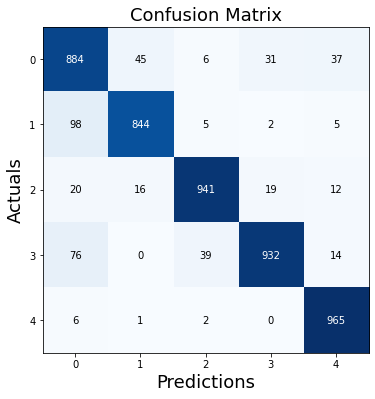

In [24]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_mtx, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [25]:
model_feat = Model(inputs=model1.input,outputs=model1.get_layer('flatten').output)
feat_train = model_feat.predict(train_x)
print(feat_train.shape)
feat_test = model_feat.predict(test_x)
print(feat_test.shape)

(20000, 3600)
(5000, 3600)


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time
start0 = time.time()
sc = StandardScaler()
X_train = sc.fit_transform(feat_train)
X_test = sc.transform(feat_test)
lda = LDA(n_components=4)
lda_X_train = lda.fit_transform(X_train,np.argmax(train_y,axis=1))
lda_X_test = lda.transform(X_test)
stop0=time.time()
print(f"Training time: {stop0 - start0}s")

Training time: 80.9495496749878s


In [27]:
print(lda_X_train.shape)
print(lda_X_test.shape)

(20000, 4)
(5000, 4)


In [28]:
import time

In [29]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
t0=time.time()
svm.fit(lda_X_train,np.argmax(train_y,axis=1))
t1=time.time()
print(f"Training time: {t1-t0}s")

Training time: 0.41583871841430664s


In [30]:
t2=time.time()
Pred_labels = svm.predict(lda_X_test)
t3=time.time()
print(Pred_labels )
print(f"Testing time: {t3-t1}s")

[3 4 1 ... 3 3 2]
Testing time: 2.802701711654663s


In [31]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,Pred_labels)
print("Accuracy:",accuracy)

Accuracy: 0.9456


In [32]:
cm = confusion_matrix(target_test, Pred_labels) 
print(cm)
print(classification_report(target_test, Pred_labels))
speci(cm)

[[ 933   28   16   18    8]
 [  63  881    9    1    0]
 [  41   13  936   13    5]
 [  40    0    8 1010    3]
 [   6    0    0    0  968]]
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89      1003
         1.0       0.96      0.92      0.94       954
         2.0       0.97      0.93      0.95      1008
         3.0       0.97      0.95      0.96      1061
         4.0       0.98      0.99      0.99       974

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9302093718843469
Specificity of  Non-ecotic beats (normal beat)  0.9494620965724293
Sensitivity of  Supraventricular ectopic beats  0.9234800838574424
Specificity of  Supraventricular ectopic beats  0.9508156203657934
Sensitivity of  Ventricular ectopic beats   0.9285714285714286
Specificity of  Ventricular ectopic bea

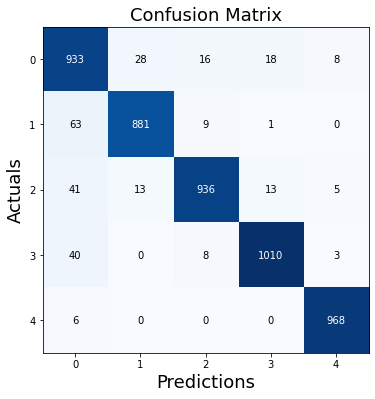

In [33]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [34]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
t4=time.time()
knn.fit(lda_X_train,np.argmax(train_y,axis=1))
t5=time.time()
print(f"Training time: {t5-t4}s")

Training time: 0.03840899467468262s


In [35]:
t6=time.time()
knn_labels = knn.predict(lda_X_test)
t7=time.time()
print(knn_labels )
print(f"Testing time: {t7-t6}s")

[3 4 1 ... 3 3 2]
Testing time: 0.3227651119232178s


In [36]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,knn_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, knn_labels) 
print(cm)
print(classification_report(target_test, knn_labels))
speci(cm)

Accuracy: 0.9528
[[ 912   38   15   29    9]
 [  44  896   11    3    0]
 [  25   16  939   21    7]
 [  13    0    3 1045    0]
 [   2    0    0    0  972]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      1003
         1.0       0.94      0.94      0.94       954
         2.0       0.97      0.93      0.95      1008
         3.0       0.95      0.98      0.97      1061
         4.0       0.98      1.00      0.99       974

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.909272183449651
Specificity of  Non-ecotic beats (normal beat)  0.9637227920940705
Sensitivity of  Supraventricular ectopic beats  0.939203354297694
Specificity of  Supraventricular ectopic beats  0.9560059317844785
Sensitivity of  Ventricular ectopic beats   0.9315476190476191
Specificity of  Ventricu

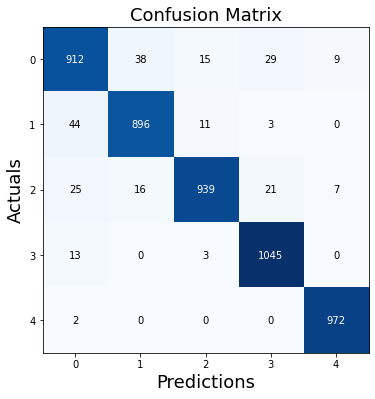

In [37]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [38]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid')
t8=time.time()
svclassifier.fit(lda_X_train,np.argmax(train_y,axis=1))
t9=time.time()
print(f"Training time: {t9-t8}s")

Training time: 0.4910874366760254s


In [39]:
t10=time.time()
svm_labels = svclassifier.predict(lda_X_test)
t11=time.time()
print(svm_labels )
print(f"Testing time: {t11-t10}s")

[3 4 1 ... 3 3 2]
Testing time: 0.20147466659545898s


In [40]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,svm_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, svm_labels) 
print(cm)
print(classification_report(target_test, svm_labels))
speci(cm)

Accuracy: 0.9392
[[ 902   47   16   24   14]
 [  51  893    7    2    1]
 [  19   23  922   36    8]
 [  32    0    8 1010   11]
 [   5    0    0    0  969]]
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      1003
         1.0       0.93      0.94      0.93       954
         2.0       0.97      0.91      0.94      1008
         3.0       0.94      0.95      0.95      1061
         4.0       0.97      0.99      0.98       974

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.8993020937188435
Specificity of  Non-ecotic beats (normal beat)  0.9492119089316988
Sensitivity of  Supraventricular ectopic beats  0.9360587002096437
Specificity of  Supraventricular ectopic beats  0.939940682155215
Sensitivity of  Ventricular ectopic beats   0.9146825396825397
Specificity of  Ventric

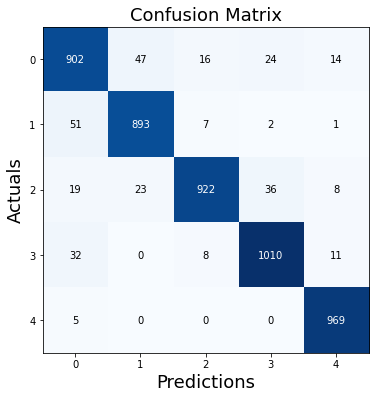

In [41]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [42]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
t12=time.time()
svclassifier.fit(lda_X_train,np.argmax(train_y,axis=1))
t13=time.time()
print(f"Training time: {t13-t12}s")

Training time: 0.9530572891235352s


In [43]:
t14=time.time()
svm_labels = svclassifier.predict(lda_X_test)
t15=time.time()
print(svm_labels )
print(f"Testing time: {t15-t14}s")

[3 4 1 ... 3 3 2]
Testing time: 0.19575047492980957s


In [44]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,svm_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, svm_labels) 
print(cm)
print(classification_report(target_test, svm_labels))
speci(cm)

Accuracy: 0.8934
[[965  11  15   7   5]
 [169 775   8   2   0]
 [123  16 835  14  20]
 [109   0   1 951   0]
 [ 33   0   0   0 941]]
              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80      1003
         1.0       0.97      0.81      0.88       954
         2.0       0.97      0.83      0.89      1008
         3.0       0.98      0.90      0.93      1061
         4.0       0.97      0.97      0.97       974

    accuracy                           0.89      5000
   macro avg       0.92      0.89      0.90      5000
weighted avg       0.92      0.89      0.90      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9621136590229312
Specificity of  Non-ecotic beats (normal beat)  0.8761571178383788
Sensitivity of  Supraventricular ectopic beats  0.8123689727463312
Specificity of  Supraventricular ectopic beats  0.9125061789421651
Sensitivity of  Ventricular ectopic beats   0.8283730158730159
Specificity of  Ventricular ectopic beats  0.90

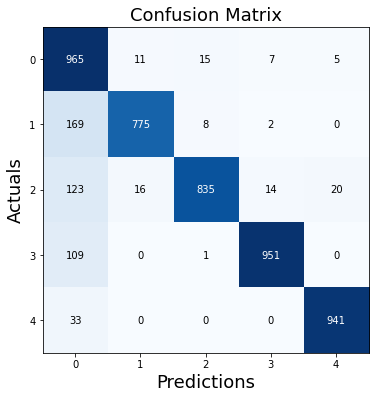

In [45]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [46]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
t16=time.time()
gnb.fit(lda_X_train,np.argmax(train_y,axis=1))
t17=time.time()
print(f"Training time: {t17-t16}s")

Training time: 0.005137443542480469s


In [47]:
t18=time.time()
gnb_labels = gnb.predict(lda_X_test)
t19=time.time()
print(gnb_labels )
print(f"Testing time: {t19-t18}s")

[3 4 1 ... 3 3 2]
Testing time: 0.0030829906463623047s


In [48]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,gnb_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, gnb_labels) 
print(cm)
print(classification_report(target_test, gnb_labels))
speci(cm)

Accuracy: 0.9438
[[ 957   17   12   13    4]
 [  87  856   11    0    0]
 [  41   11  935   16    5]
 [  47    0    8 1003    3]
 [   6    0    0    0  968]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      1003
         1.0       0.97      0.90      0.93       954
         2.0       0.97      0.93      0.95      1008
         3.0       0.97      0.95      0.96      1061
         4.0       0.99      0.99      0.99       974

    accuracy                           0.94      5000
   macro avg       0.95      0.94      0.94      5000
weighted avg       0.95      0.94      0.94      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9541375872382851
Specificity of  Non-ecotic beats (normal beat)  0.9412059044283212
Sensitivity of  Supraventricular ectopic beats  0.8972746331236897
Specificity of  Supraventricular ectopic beats  0.9547701433514583
Sensitivity of  Ventricular ectopic beats   0.9275793650793651
Specificity of  Ventri

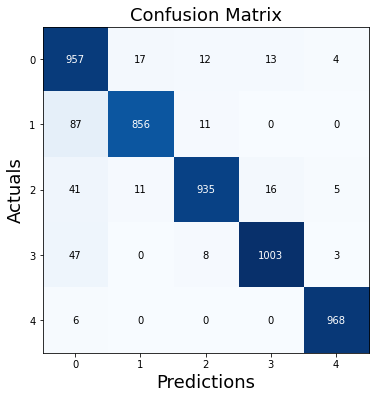

In [49]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [50]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
t20=time.time()
dt.fit(lda_X_train,np.argmax(train_y,axis=1))
t21=time.time()
print(f"Training time: {t21-t20}s")

Training time: 0.07977509498596191s


In [51]:
t22=time.time()
dt_labels = dt.predict(lda_X_test)
t23=time.time()
print(dt_labels )
print(f"Testing time: {t23-t22}s")

[3 4 1 ... 3 3 2]
Testing time: 0.00213623046875s


In [52]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,dt_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, dt_labels) 
print(cm)
print(classification_report(target_test, dt_labels))
speci(cm)

Accuracy: 0.9596
[[ 919   43   21   16    4]
 [  38  908    8    0    0]
 [  38   11  936   21    2]
 [   0    0    0 1061    0]
 [   0    0    0    0  974]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      1003
         1.0       0.94      0.95      0.95       954
         2.0       0.97      0.93      0.95      1008
         3.0       0.97      1.00      0.98      1061
         4.0       0.99      1.00      1.00       974

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9162512462612163
Specificity of  Non-ecotic beats (normal beat)  0.9704778583937953
Sensitivity of  Supraventricular ectopic beats  0.9517819706498952
Specificity of  Supraventricular ectopic beats  0.9614434008897677
Sensitivity of  Ventricular ectopic beats   0.9285714285714286
Specificity of  Ventri

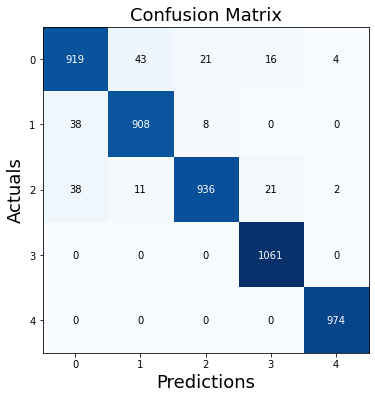

In [53]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [54]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier()
t24=time.time()
rfc.fit(lda_X_train,np.argmax(train_y,axis=1))
t25=time.time()
print(f"Training time: {t25-t24}s")

Training time: 2.465975761413574s


In [55]:
t26=time.time()
rfc_labels = rfc.predict(lda_X_test)
t27=time.time()
print(rfc_labels )
print(f"Testing time: {t27-t26}s")

[3 4 1 ... 3 3 2]
Testing time: 0.055420875549316406s


In [56]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,rfc_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, rfc_labels) 
print(cm)
print(classification_report(target_test, rfc_labels))
speci(cm)

Accuracy: 0.9664
[[ 938   26   19   14    6]
 [  28  914    8    4    0]
 [  28   15  945   16    4]
 [   0    0    0 1061    0]
 [   0    0    0    0  974]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1003
         1.0       0.96      0.96      0.96       954
         2.0       0.97      0.94      0.95      1008
         3.0       0.97      1.00      0.98      1061
         4.0       0.99      1.00      0.99       974

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9351944167497508
Specificity of  Non-ecotic beats (normal beat)  0.9742306730047535
Sensitivity of  Supraventricular ectopic beats  0.9580712788259959
Specificity of  Supraventricular ectopic beats  0.9683638161146811
Sensitivity of  Ventricular ectopic beats   0.9375
Specificity of  Ventricular ectopi

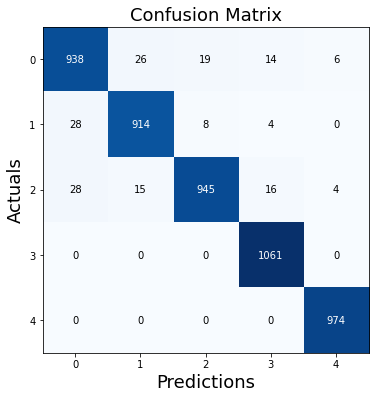

In [57]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [58]:
target= X_train_df[X_train_df.shape[1]-1]
feature = X_train_df.iloc[:,:X_train_df.shape[1]-1].values
feature = feature.reshape(len(feature), feature.shape[1],1)

In [59]:
feat = model_feat.predict(feature)
X_train = sc.fit_transform(feat)
lda = LDA(n_components=4)
lda_train = lda.fit_transform(X_train, target)
print(lda_train.shape)

(25000, 4)


In [60]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(rfc, lda_train, target, scoring='accuracy', cv=10)
print(score)

[0.9868 0.9904 0.9884 0.9884 0.9916 0.9896 0.9916 0.9916 0.9908 0.9896]


In [61]:
print("Avg :",np.average(score))

Avg : 0.98988
